# Prerequisites
Before you can execute this notebook you'll need the graph logs which you can generate by running the `nervenet_graph_generation.py` in the `NerveNet` subfolder

In [1]:
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_sparse
import networkx as nx

In [2]:
from NerveNet.graph_util.mujoco_parser import parse_mujoco_graph
from NerveNet.graph_util.mujoco_parser_settings import  RootRelationOption

In [5]:
#some settings
edge_colors = {
    10:"blue", # root-body
    3:"green", # body-body
    6:"blue", # joint-body
}

def visualize_task_graph(task_name:str,
                         figsize=(10, 10),
                         use_sibling_relations: bool = True,
                         root_relation_option: RootRelationOption = RootRelationOption.BODY):
    fig = plt.figure(figsize=figsize)
    
    task_log = parse_mujoco_graph(task_name=task_name, 
        use_sibling_relations=use_sibling_relations,
        root_relation_option=root_relation_option)
    
    node_colors = {
        "red": task_log["node_type_dict"]["root"],
        "blue": task_log["node_type_dict"]["joint"],
        "black": task_log["node_type_dict"]["body"],
    }

    node_names = {node["id"]: node["raw_name"] for node in task_log["tree"] if "raw_name" in node.keys()}
    node_names[0] = "root"
    
    # Generate graph structure
    G = nx.Graph()
    for i in range(task_log["num_nodes"]):
        G.add_node(i)
        for j in range(i, task_log["num_nodes"]):
            if task_log["relation_matrix"][i][j] != 0:
                G.add_edge(i, j)
    
    pos = nx.spring_layout(G)#, pos={0: np.array([ 0, 0])})

    options = {"node_size": 100, "alpha": 0.8}
    for color, nodes in node_colors.items():
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, **options)
        nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=color, **options)


    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    for p in pos:  # raise text positions
        pos[p][1] += 0.055
    nx.draw_networkx_labels(G, pos, node_names, font_size=12)
    
    plt.show()
    return task_log

In [6]:
#ant_log = visualize_task_graph("AntS-v1")

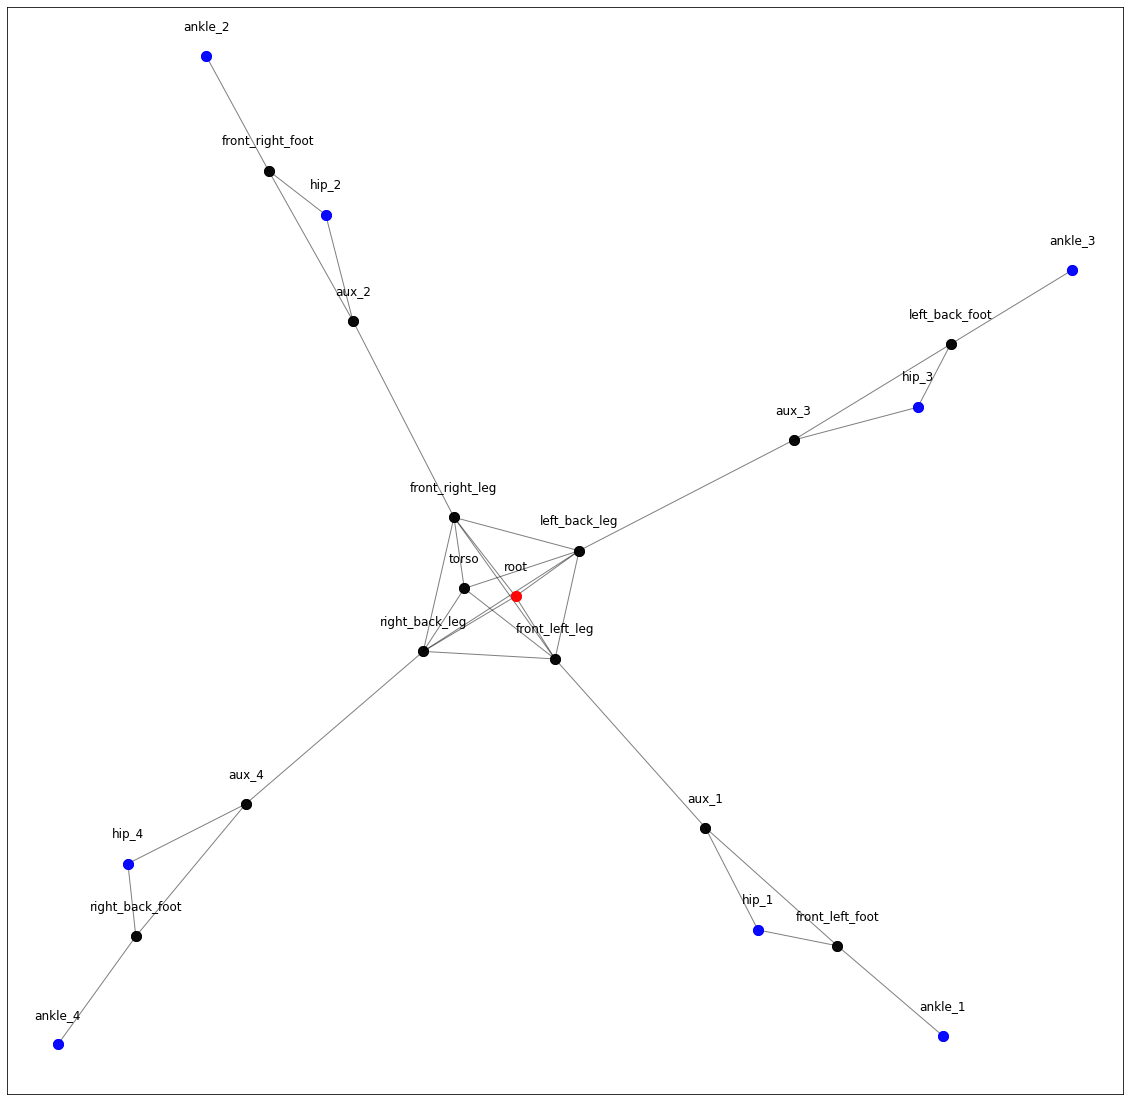

In [13]:
ant_bullet_log = visualize_task_graph("AntBulletEnv-v0",
                                        figsize=(20,20),
                                        use_sibling_relations = True,
                                        root_relation_option = RootRelationOption.NONE
                                        )

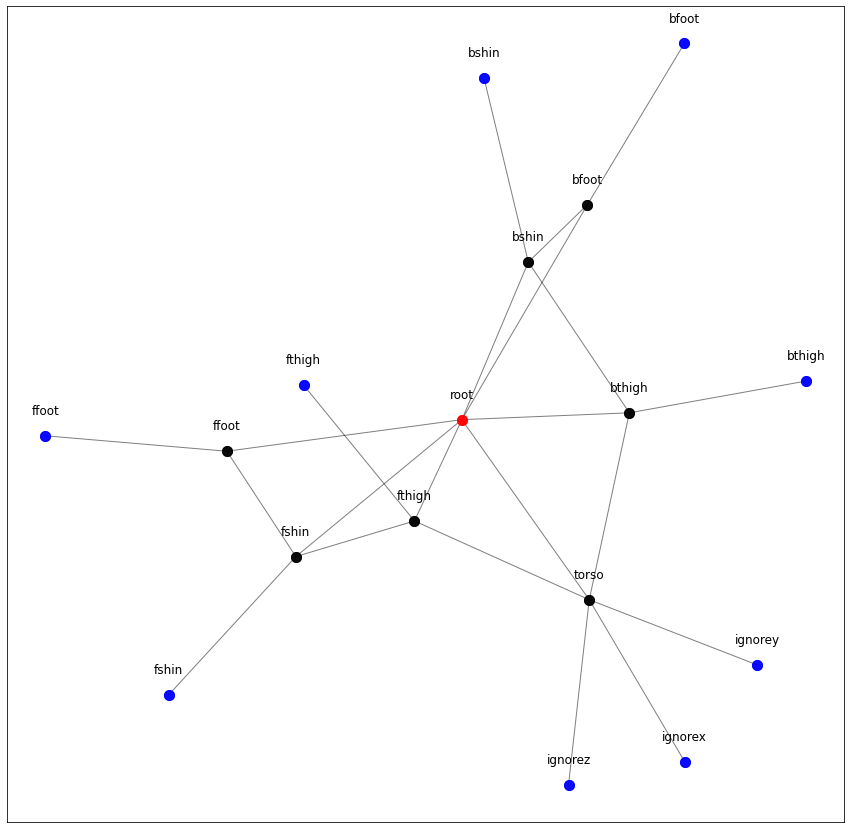

In [8]:
HalfCheetah_log = visualize_task_graph("HalfCheetah-v1",
                                        figsize=(15,15),
                                        use_sibling_relations = False,
                                        root_relation_option = RootRelationOption.BODY)

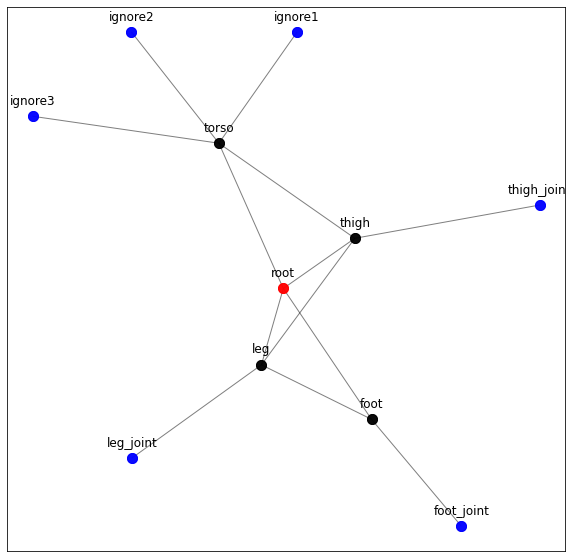

In [72]:
Hopper_log = visualize_task_graph("HopperBulletEnv-v0", figsize=(10,10),
                                        use_sibling_relations = False,
                                        root_relation_option = RootRelationOption.BODY)

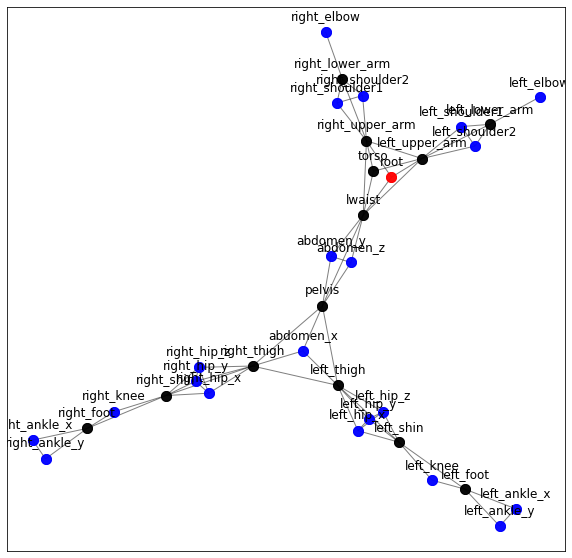

In [80]:
Humanoid_log = visualize_task_graph("Humanoid-v1",
                                    use_sibling_relations = True,
                                    root_relation_option = RootRelationOption.NONE)

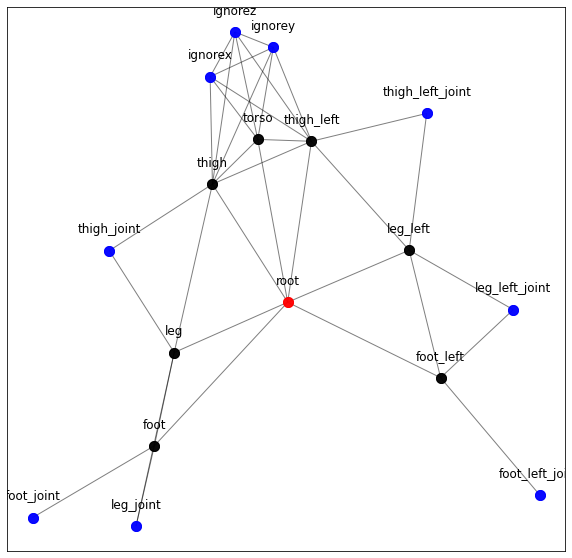

In [74]:
WalkersKangaroo_log = visualize_task_graph("Walker2DBulletEnv-v0")

In [46]:
#WalkersOstrich_log = visualize_task_graph("WalkersOstrich-v1")

In [81]:
ant_bullet_log.keys()

dict_keys(['tree', 'relation_matrix', 'node_type_dict', 'output_type_dict', 'output_list', 'obs_input_mapping', 'static_input_mapping', 'input_type_dict', 'num_nodes', 'num_node_features'])

In [164]:
relation_matrix = ant_bullet_log["relation_matrix"]
obs_input_mapping = ant_bullet_log["obs_input_mapping"]
input_type_dict = ant_bullet_log["input_type_dict"]
static_input_mapping = ant_bullet_log["static_input_mapping"]
num_nodes = ant_bullet_log["num_nodes"]
num_node_features = ant_bullet_log["num_node_features"]

In [165]:
batch_size = 2
observation_sample_size = max(list(obs_input_mapping.values()))[0]+ 1
observations = torch.arange(batch_size * observation_sample_size).reshape((batch_size, observation_sample_size)).to(torch.float32,)

In [166]:
observations

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.],
        [28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
         42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.]])

In [116]:
from NerveNet.graph_util.observation_mapper import observations_to_node_attributes
observations_to_node_attributes(observations,
                                obs_input_mapping,
                                static_input_mapping,
                                num_nodes,
                                num_node_features).shape

torch.Size([1, 22, 16])

In [167]:
batch_size, observation_sample_size = observations.shape
# check that there is a mapping for every element of the observation vector
assert max(list(obs_input_mapping.values()))[
    0] + 1 == observation_sample_size

static_input_mapping = {int(k): np.concatenate(list(v.values()))
                        for k, v in static_input_mapping.items()}
static_input_mapping[0] = np.array([])

In [168]:
static_input_mapping

{4: array([  1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0., -40.,  40.]),
 6: array([  1.,   1.,   1.,  -1.,   1.,   0.,   0.,   0.,   0.,  30., 100.]),
 9: array([  1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0., -40.,  40.]),
 11: array([   1.,    1.,    1.,    1.,    1.,    0.,    0.,    0.,    0.,
        -100.,  -30.]),
 14: array([  1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0., -40.,  40.]),
 16: array([   1.,    1.,    1.,   -1.,    1.,    0.,    0.,    0.,    0.,
        -100.,  -30.]),
 19: array([  1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0., -40.,  40.]),
 21: array([  1.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,  30., 100.]),
 1: array([0.  , 0.  , 0.75]),
 2: array([0., 0., 0.]),
 3: array([0.2, 0.2, 0. ]),
 5: array([0.2, 0.2, 0. ]),
 7: array([0., 0., 0.]),
 8: array([-0.2,  0.2,  0. ]),
 10: array([-0.2,  0.2,  0. ]),
 12: array([0., 0., 0.]),
 13: array([-0.2, -0.2,  0. ]),
 15: array([-0.2, -0.2,  0. ]),
 17: array([0., 0., 0.]),
 18: arra

In [169]:
obs_input_mapping

{0: [0, 1, 2, 3, 4, 5, 6, 7],
 4: [8, 9],
 6: [10, 11],
 9: [12, 13],
 11: [14, 15],
 14: [16, 17],
 16: [18, 19],
 19: [20, 21],
 21: [22, 23],
 1: [],
 2: [],
 3: [],
 5: [24],
 7: [],
 8: [],
 10: [25],
 12: [],
 13: [],
 15: [26],
 17: [],
 18: [],
 20: [27]}

{'root': [0],
 'joint': [4, 6, 9, 11, 14, 16, 19, 21],
 'body': [1, 2, 3, 5, 7, 8, 10, 12, 13, 15, 17, 18, 20]}

In [186]:
input_mask_dict = {}
for group_name, group_nodes in input_type_dict.items():
    # assumes every node of a group has the same input sizes
    in_size = len(obs_input_mapping[group_nodes[0]])
    static_in_size = len(static_input_mapping[group_nodes[0]])
    input_mask_dict[group_name] = (group_nodes, in_size + static_in_size)
input_mask_dict

{'root_mujocoroot': ([0], 8),
 'aux': ([3, 8, 13, 18], 3),
 'torso': ([1], 3),
 'leg': ([2, 7, 12, 17], 3),
 'foot': ([5, 10, 15, 20], 4),
 'hip': ([4, 9, 14, 19], 13),
 'ankle': ([6, 11, 16, 21], 13)}

In [94]:
# ant_bullet_log["relation_matrix"]

In [171]:
attributes = -torch.ones(batch_size,
                                 num_nodes,
                                 num_node_features,
                                 dtype=torch.float32,
                                 device=observations.device)

for i in range(num_nodes):
    in_size = len(obs_input_mapping[i])
    static_in_size = len(static_input_mapping[i])

    in_mask = list(range(in_size))
    static_in_mask = list(range(in_size, in_size+static_in_size))

    attributes[:, i, in_mask] = observations[:, obs_input_mapping[i]]
    attributes[:, i, static_in_mask] = torch.from_numpy(
        static_input_mapping[i]).expand(batch_size, -1).float().to(observations.device)

In [172]:
attributes[:, input_type_dict["root_mujocoroot"]].shape

torch.Size([2, 1, 16])

In [195]:
attributes[:, input_mask_dict["foot"][0], 0:input_mask_dict["foot"][1]]

tensor([[[24.0000,  0.2000,  0.2000,  0.0000],
         [25.0000, -0.2000,  0.2000,  0.0000],
         [26.0000, -0.2000, -0.2000,  0.0000],
         [27.0000,  0.2000, -0.2000,  0.0000]],

        [[52.0000,  0.2000,  0.2000,  0.0000],
         [53.0000, -0.2000,  0.2000,  0.0000],
         [54.0000, -0.2000, -0.2000,  0.0000],
         [55.0000,  0.2000, -0.2000,  0.0000]]])

In [197]:
0

0

In [196]:
1 

1

In [79]:
ant_bullet_log["input_type_dict"]

{'root': [0],
 'aux': [3, 8, 13, 18],
 'torso': [1],
 'leg': [2, 7, 12, 17],
 'foot': [5, 10, 15, 20],
 'hip': [4, 9, 14, 19],
 'ankle': [6, 11, 16, 21]}

In [80]:
[node for node in ant_bullet_log["tree"] if node["id"] in ant_bullet_log["output_list"]]

[{'type': 'joint',
  'is_output_node': True,
  'is_foot': False,
  'raw_name': 'hip_1',
  'name': 'joint_hip_1',
  'id': 4,
  'parent': 3,
  'info': {'axis': '0 0 1',
   'name': 'hip_1',
   'pos': '0.0 0.0 0.0',
   'range': '-40 40',
   'type': 'hinge'}},
 {'type': 'joint',
  'is_output_node': True,
  'is_foot': False,
  'raw_name': 'ankle_1',
  'name': 'joint_ankle_1',
  'id': 6,
  'parent': 5,
  'info': {'axis': '-1 1 0',
   'name': 'ankle_1',
   'pos': '0.0 0.0 0.0',
   'range': '30 100',
   'type': 'hinge'}},
 {'type': 'joint',
  'is_output_node': True,
  'is_foot': False,
  'raw_name': 'hip_2',
  'name': 'joint_hip_2',
  'id': 9,
  'parent': 8,
  'info': {'axis': '0 0 1',
   'name': 'hip_2',
   'pos': '0.0 0.0 0.0',
   'range': '-40 40',
   'type': 'hinge'}},
 {'type': 'joint',
  'is_output_node': True,
  'is_foot': False,
  'raw_name': 'ankle_2',
  'name': 'joint_ankle_2',
  'id': 11,
  'parent': 10,
  'info': {'axis': '1 1 0',
   'name': 'ankle_2',
   'pos': '0.0 0.0 0.0',
   'r

In [ ]:
dict(enumerate([node for node in ant_bullet_log["tree"] if node["type"] == "joint"]))